In [188]:
import os 
import cv2
import numpy as np
import random
import copy
from scipy.stats import norm
from matplotlib import pyplot as plt
from PIL import Image


class mix_augmentaion():
    def __init__(self):
        self.random_parameter()
    def random_parameter(self,h=None,w=None,rain_slant=None,spotlignt_position=None,spotlight_reverse=None,spotlight_transparency=None,gamma=None,pixelate_blocks=None):
        #rain
        if rain_slant is None:
            rain_slant = np.random.randint(-10, 10) # generate random slant if no slant value is given
        #spot_light
        if spotlight_reverse is None:
            spotlight_reverse=False
            if np.random.random(size=1)>0.5:
                spotlight_reverse=True
        if spotlight_transparency is None:
            spotlight_transparency = random.uniform(0.5, 0.85)
        if spotlignt_position is None:
            spotlignt_position = [(random.random(), random.random())]

        #gamma
        if gamma is None:
            gamma = np.random.randint(40,91) / 100.0
        if pixelate_blocks is None:
            pixelate_blocks = np.random.randint(53,77)#0.2 : 0.3 hw
        if h is None:
            self.h = None
        if w is None:
            self.w = None
        
        self.rain_slant = rain_slant
        self.rain_drops = None
        self.rain_width = None

        self.spotlight_reverse = spotlight_reverse
        self.spotlight_transparency = spotlight_transparency
        self.spotlignt_position = spotlignt_position
        self.gamma = gamma
        self.pixelate_blocks = pixelate_blocks
    

        

        
    def generate_random_lines(self,imshape, slant,step_ratio=1.0):
        drops = []
        drop_width = []
        area = imshape[0] * imshape[1]
        drops_num = int(area//np.random.randint(600, 700)*step_ratio)

        for i in range(drops_num): ## If You want heavy rain, try increasing this
            if slant<0:
                x1 = np.random.randint(slant, imshape[1])
            else:
                x1 = np.random.randint(0, imshape[1]-slant)
            drop_length = np.random.randint(10, 60)
            y1 = np.random.randint(0, imshape[0]-drop_length)
            x2 = x1 + slant
            y2 = y1 + drop_length
            drops.append((x1, y1, x2, y2))
            drop_width.append(np.random.randint(1, 3))


        return drops,drop_width


    def rain_process(self,image, rain_drops, drop_color,_drop_width):
        imshape = image.shape  
        image_t = image.copy()
        for idx,rain_drop in enumerate(rain_drops):
            pt1 = (rain_drop[0], rain_drop[1])
            pt2 = (rain_drop[2], rain_drop[3])
            drop_width = _drop_width[idx]
            cv2.line(image_t, pt1, pt2, drop_color, drop_width)

        return image_t


    def add_rain(self,image, slant=None, drop_color=(200,200,200)):
        imshape = image.shape
        if slant is None:
            slant = np.random.randint(-10, 10) # generate random slant if no slant value is given
        rain_drops = self.generate_random_lines(imshape, slant)
        output = self.rain_process(image, rain_drops, drop_color)

        return output

    def add_rain_step(self,image, slant=None, drop_color=(200,200,200),step_ratio=1.0,return_slant=False):
        imshape = image.shape
        if slant is None:
            slant = np.random.randint(-10, 10) # generate random slant if no slant value is given
        if self.rain_drops is None:
            self.rain_drops, self.rain_width = self.generate_random_lines(imshape, slant)
            
        rain_drops = self.rain_drops
        rain_width = self.rain_width
        len_rain = len(rain_drops)
        final_rains = rain_drops[:int(step_ratio*len_rain)]
        final_rain_width = rain_width[:int(step_ratio*len_rain)]
        
        output = self.rain_process(image, final_rains, drop_color,final_rain_width)
        if return_slant:
            return output,slant
        else:
            return output



    def generate_spot_light_mask(self,
                                 mask_size,
                                 position=None,
                                 max_brightness=255,
                                 min_brightness=0,
                                 mode="gaussian",
                                 linear_decay_rate=None,
                                 speedup=False,
                                 reverse=False):
        """
        Generate decayed light mask generated by spot light given position, direction. Multiple spotlights are accepted.
        Args:
            mask_size: tuple of integers (w, h) defining generated mask size
            position: list of tuple of integers (x, y) defining the center of spotlight light position,
                      which is the reference point during rotating, format=[(w1,h1), (w2,h2)]
            max_brightness: integer that max brightness in the mask
            min_brightness: integer that min brightness in the mask
            mode: the way that brightness decay from max to min: linear or gaussian
            linear_decay_rate: only valid in linear_static mode. Suggested value is within [0.2, 2]
            speedup: use `shrinkage then expansion` strategy to speed up vale calculation
            reverse: center point is dark or bright (default: bright)
        Return:
            light_mask: ndarray in float type consisting value from max_brightness to min_brightness. If in 'linear' mode
                        minimum value could be smaller than given min_brightness.
        """
        if position is None:
            position = [(random.randint(0, mask_size[0]), random.randint(0, mask_size[1]))]
        if linear_decay_rate is None:
            if mode == "linear_static":
                linear_decay_rate = random.uniform(0.25, 1)
        assert mode in ["linear", "gaussian"], \
            "mode must be linear_dynamic, linear_static or gaussian"
        mask = np.zeros(shape=(mask_size[1], mask_size[0]), dtype=np.float32)
        if mode == "gaussian":
            mu = np.sqrt(mask.shape[0]**2+mask.shape[1]**2)
            dev = mu / 3.5
            mask = self._decay_value_radically_norm_in_matrix(mask_size, position, max_brightness, min_brightness, dev)
        mask = np.asarray(mask, dtype=np.uint8)
        # add median blur
        mask = cv2.medianBlur(mask, 5)
        if reverse:
            mask = 255 - mask
        return mask

    def _decay_value_radically_norm_in_matrix(self,mask_size, centers, max_value, min_value, dev):
        """
        _decay_value_radically_norm function in matrix format
        """
        center_prob = norm.pdf(0, 0, dev)
        x_value_rate = np.zeros((mask_size[1], mask_size[0]))
        for center in centers:
            coord_x = np.arange(mask_size[0])
            coord_y = np.arange(mask_size[1])
            xv, yv = np.meshgrid(coord_x, coord_y)
            dist_x = xv - center[0]
            dist_y = yv - center[1]
            dist = np.sqrt(np.power(dist_x, 2) + np.power(dist_y, 2))
            x_value_rate += norm.pdf(dist, 0, dev) / center_prob
        mask = x_value_rate * (max_value - min_value) + min_value
        mask[mask > 255] = 255
        return mask



    def add_spot_light_step(self,image, light_position=None, max_brightness=255, min_brightness=0,
                       mode='gaussian', linear_decay_rate=None, transparency=None,step_ratio=1.0,reverse=False):
        """
        Add mask generated from spot light to given image
        """
        image=copy.deepcopy(image)
        reverse=False
        if np.random.random(size=1)>0.5:
            reverse=True
        if transparency is None:
            transparency = random.uniform(0.5, 0.85)
        transparency = 1-(1-transparency)*step_ratio
        frame = image
        frame = np.asarray(frame, dtype=np.float32)
        height, width, _ = frame.shape
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        mask = self.generate_spot_light_mask(mask_size=(width, height),
                                        position=light_position,
                                        max_brightness=max_brightness,
                                        min_brightness=min_brightness,
                                        mode=mode,
                                        linear_decay_rate=linear_decay_rate,
                                        reverse=reverse,
                                       )
        hsv[:, :, 2] = hsv[:, :, 2] * transparency + mask * (1 - transparency)
        #print(width)
        #print(height)
        #plt.imshow(mask)
        frame = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
        frame[frame > 255] = 255
        frame[frame < 0] = 0
        frame = np.asarray(frame, dtype=np.uint8)
        return frame

    def adjust_gamma(self,image, gamma=None):
        image=copy.deepcopy(image)
        # build a lookup table mapping the pixel values [0, 255] to
        # their adjusted gamma values
        if gamma is None:
            gamma = np.random.randint(40,91) / 100.0
            #gamma = np.random.randint(50,150) / 100.0
        invGamma = 1.0 / gamma
        table = np.array([((i / 255.0) ** invGamma) * 255
                          for i in np.arange(0, 256)]).astype("uint8")
        # apply gamma correction using the lookup table
        #print(table)
        return cv2.LUT(image, table)

    def pixelate(self,image, blocks=None,step_ratio=1.0):
        input_image_copy=copy.deepcopy(image)
        # divide the input image into NxN blocks
        st_ratio=0.5+step_ratio*0.5
        if blocks is None:
            blocks = np.random.randint(120,151)

        (h, w) = image.shape[:2]
        #Xblocks=w-(w-blocks)*step_ratio
        #Yblocks=h-(h-blocks)*step_ratio
        Xblocks=blocks*st_ratio+(1-st_ratio)*w
        Yblocks=blocks*st_ratio+(1-st_ratio)*h
        #print(Xblocks)


        xSteps = np.linspace(0, w, int(Xblocks) + 1, dtype="int")
        ySteps = np.linspace(0, h, int(Yblocks) + 1, dtype="int")
        #print(len(xSteps),len(ySteps))

        #print(xSteps)
        #print(h)
        #print(w)
        # loop over the blocks in both the x and y direction
        limited=False
        for i in range(1, len(ySteps)):
            for j in range(1, len(xSteps)):
                # compute the starting and ending (x, y)-coordinates
                # for the current block
                startX = xSteps[j - 1]
                startY = ySteps[i - 1]
                endX = xSteps[j]
                endY = ySteps[i]
                if endX-startX<2 and endY-startY<2:
                    #limited=True
                    #print('%d %d %d %d'%(startX,endX,startY,endY))

                    #print('limited to original image')
                    break

                roi = input_image_copy[startY:endY, startX:endX]
                #print(roi)
                #print('%d %d %d %d'%(startX,endX,startY,endY))
                (B, G, R) = [int(x) for x in cv2.mean(roi)[:3]]

                cv2.rectangle(input_image_copy, (startX, startY), (endX, endY), (B, G, R), -1)
            #if limited:
            #    break
        # return the pixelated blurred image
        if limited:
            return image
        else:
            return input_image_copy
        
    def pixelate_cv2(self,image, blocks=None,step_ratio=1.0):
        input_image_copy=copy.deepcopy(image)
        # divide the input image into NxN blocks
        if step_ratio==0:
            st_ratio=0
        else:
            st_ratio=0.5+step_ratio*0.5

        if blocks is None:
            blocks = np.random.randint(120,151)

        (h, w) = image.shape[:2]
        Xblocks=blocks*st_ratio+(1-st_ratio)*w
        Yblocks=blocks*st_ratio+(1-st_ratio)*h

        img = cv2.resize(input_image_copy,(int(Xblocks),int(Yblocks)),interpolation=cv2.INTER_AREA)
        #print(img.shape)
        img = cv2.resize(img,(w, h),interpolation=cv2.INTER_AREA)
        return img

        
        
    def mix_aug(self,img,step,random=False):
        if random:
            self.random_parameter()
        #print(np.max(img))
        #print(np.min(img))
        img = img.astype(np.uint8)
        height, width, _ = img.shape
        pos = [(self.spotlignt_position[0][0]*width,self.spotlignt_position[0][1]*height)]
        #self.pixelate_blocks=60
        img = self.add_rain_step(img,step_ratio=step,slant = self.rain_slant)
        img = self.add_spot_light_step(img,step_ratio=step,light_position=pos,transparency=self.spotlight_transparency,reverse=self.spotlight_reverse)
        #print(1-(1-self.gamma)*step)
        #print('dsadsada')
        img = self.adjust_gamma(img,gamma=1-(1-self.gamma)*step)
        #img = self.pixelate(img,blocks=self.pixelate_blocks,step_ratio=step)

        img = self.pixelate_cv2(img,blocks=self.pixelate_blocks,step_ratio=step)

        #img = self.pixelate_cv2(img,blocks=self.pixelate_blocks,step_ratio=step)

        return img


torch.Size([4, 3, 256, 256])
cuda:0
4
tensor([[-0.0510,  0.2157,  0.1765,  ..., -0.4667, -0.4824, -0.4902],
        [-0.1294,  0.0902, -0.0196,  ..., -0.3098, -0.3490, -0.3020],
        [-0.0980, -0.0118, -0.1137,  ...,  0.4431,  0.4275,  0.4118],
        ...,
        [-0.4588, -0.4745, -0.4902,  ...,  0.0039, -0.0275, -0.0353],
        [-0.4667, -0.4510, -0.4745,  ..., -0.0118,  0.0431, -0.0118],
        [-0.4353, -0.4431, -0.4588,  ..., -0.0039,  0.0275,  0.0196]],
       device='cuda:0')
255.0
0.0
0.9199999999999999
dsadsada
255
0
255.0
20.999998
0.9199999999999999
dsadsada
255
16
255.0
0.0
0.9199999999999999
dsadsada
255
0
255.0
0.0
0.9199999999999999
dsadsada
255
0
torch.Size([3, 256, 256])
255.0
0.0
0.9199999999999999
dsadsada
255
0
255.0
0.0
0.888
dsadsada
255
0
0.0
0.0
torch.Size([3, 256, 256])
255.0
20.999998
0.9199999999999999
dsadsada
255
16
255.0
20.999998
0.888
dsadsada
255
14
0.0
0.0
torch.Size([3, 256, 256])
255.0
0.0
0.9199999999999999
dsadsada
255
0
255.0
0.0
0.888
dsa

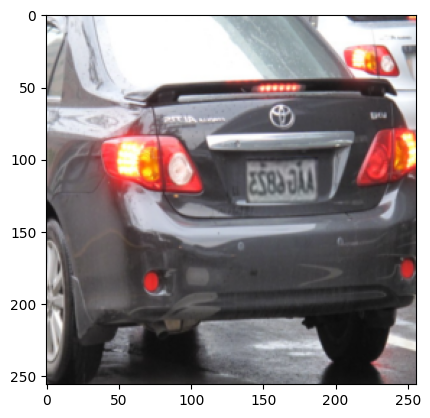

In [190]:
#img = Image.open('03-1.jpg')

#img = img.convert('RGB')
#print(img)
#pixels = list(img.getdata())
#print(pixels)
device = torch.device("cuda:0")

def torchcuda2npy(x):    
    return (x.detach().cpu().numpy().transpose([1,2,0])+1)/2
def npy2torchcuda(x,device):
    return torch.tensor(((x*2)-1).transpose([2,0,1]), device=device)
    #return torch.tensor(x.transpose([2,0,1]), device=device)
    
def batch_data_add_licence_aug(imgbf,t,random=False):
    after_img = torch.full(imgbf.shape,0,dtype=imgbf.dtype,device=imgbf.device)
    for idx, oneimg in enumerate(imgbf):
        img_np = torchcuda2npy(copy.deepcopy(oneimg))
        img_aug = mix_a.mix_aug(img_np*255,t,random=random)
        #img_aug = img_np*255
        #img_np7 = mix_a.mix_aug(img_np*255,t,random=random)




        img_inv = npy2torchcuda(img_aug/255,imgbf.device)
        after_img[idx] = img_inv
    return after_img

    

import torch
imgbf= torch.load('imgbffunc.pt')
#imgaf= torch.load('imgaffunc.pt')
print(imgbf.shape)
print(imgbf.device)
#print(imgaf.shape)
mix_a = mix_augmentaion()
batchsz=imgbf.shape[0]
print(batchsz)
print(imgbf[0][0])
after_img = torch.full(imgbf.shape,0,dtype=imgbf.dtype,device=imgbf.device)
img_aug = batch_data_add_licence_aug(imgbf,0.5)

for idx, oneimg in enumerate(imgbf):
    print(oneimg.shape)
    img_np = torchcuda2npy(copy.deepcopy(oneimg))
    img_np5 = mix_a.mix_aug(img_np*255,0.5)
    img_np7 = mix_a.mix_aug(img_np*255,0.7)
    
    
    
    img_inv = npy2torchcuda(img_np,imgbf.device)
    img_np2 = torchcuda2npy(img_inv)
    plt.imshow(img_np)
    #print(np.max(img_np-oneimg.detach().cpu().numpy().transpose([1,2,0])))
    #print(np.min(img_np-oneimg.detach().cpu().numpy().transpose([1,2,0])))
    print(np.max((img_inv-oneimg).detach().cpu().numpy().transpose([1,2,0])))
    print(np.min((img_inv-oneimg).detach().cpu().numpy().transpose([1,2,0])))
    after_img[idx] = img_inv
    
print(imgbf[0][0])
print(np.max((after_img[1]-imgbf[1]).detach().cpu().numpy().transpose([1,2,0])))
print(np.min((after_img[1]-imgbf[1]).detach().cpu().numpy().transpose([1,2,0])))

print(np.max((img_aug[1]-imgbf[1]).detach().cpu().numpy().transpose([1,2,0])))
print(np.min((img_aug[1]-imgbf[1]).detach().cpu().numpy().transpose([1,2,0])))




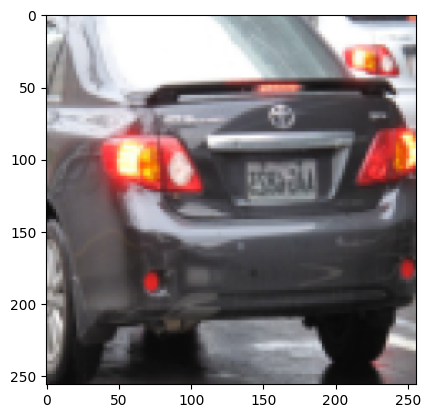

In [191]:
plt.imshow(img_np5)


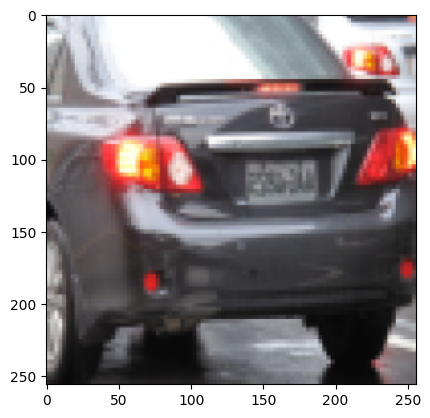

In [192]:
plt.imshow(img_np7)


1.0
0.0


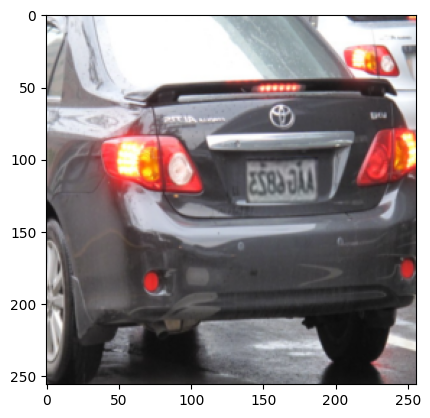

In [196]:
plt.imshow(img_np2)
print(np.max(img_np2))
print(np.min(img_np2))


1.0
0.0039215684


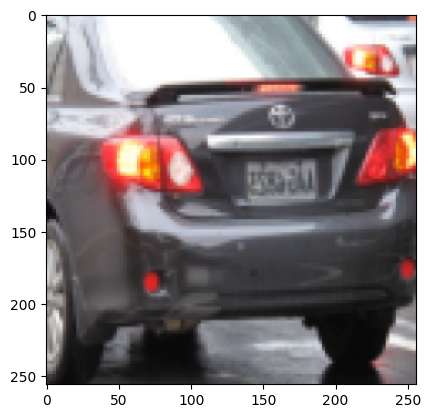

In [195]:
img_np3 = torchcuda2npy(img_aug[3])
print(np.max(img_np3))
print(np.min(img_np3))

plt.imshow(img_np3)